In [5]:
# !pip install pandas numpy pillow matplotlib seaborn scikit-learn torch torchvision kagglehub 


import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub


In [6]:
class JGEKDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, teacher_logits, student_logits):
        teacher_probs = torch.softmax(teacher_logits, dim=1)
        student_probs = torch.softmax(student_logits, dim=1)

        teacher_joint_graph = torch.bmm(teacher_probs.unsqueeze(2), teacher_probs.unsqueeze(1))
        student_joint_graph = torch.bmm(student_probs.unsqueeze(2), student_probs.unsqueeze(1))

        teacher_flat = teacher_joint_graph.view(teacher_joint_graph.size(0), -1)
        student_flat = student_joint_graph.view(student_joint_graph.size(0), -1)

        epsilon = 1e-12
        log_student_flat = torch.log(student_flat + epsilon)

        kd_loss = -torch.sum(teacher_flat * log_student_flat, dim=1).mean()
        return kd_loss


In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
        self.label_map = {name: i for i, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            image = Image.fromarray(np.uint8(np.random.rand(224, 224, 3) * 255))

        label_name = self.dataframe.iloc[idx]['label']
        label = self.label_map[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
def get_data_loaders(df, img_size=224, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    if len(df) < 5:
        train_df = df
        test_df = df
    else:
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

    train_dataset = BrainTumorDataset(train_df, transform)
    test_dataset = BrainTumorDataset(test_df, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset.class_names


In [9]:
def train_and_validate(student_model, teacher_model, train_loader, test_loader, optimizer,
                       ce_loss_fn, kd_loss_fn, lambda_weight, epochs, device):
    # function body

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher_model(images)

            student_logits = student_model(images)

            ce_loss = ce_loss_fn(student_logits, labels)
            kd_loss = kd_loss_fn(teacher_logits, student_logits)
            total_loss = ce_loss + lambda_weight * kd_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        student_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_accuracy = 100 * correct / total if total > 0 else 0.0
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%")

    return train_losses, test_accuracies


In [10]:
def evaluate_metrics(student_model, test_loader, device, class_names):
    student_model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Student Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [11]:
def plot_metrics(train_losses, test_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
print(train_and_validate)


<function train_and_validate at 0x138928680>


Path to dataset files: /Users/siyran/Downloads/brisc2025/classification_task/test
Training on: mps


/var/folders/cg/5bwxxnzs74n3k54n54wbwcjh0000gn/T/ipykernel_68531/301203452.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label', group_keys=False).apply(


Starting JGEKD training on mps for 10 epochs...
Epoch 1/10, Train Loss: 2.4050, Test Accuracy: 96.33%
Epoch 2/10, Train Loss: 2.5023, Test Accuracy: 23.27%
Epoch 3/10, Train Loss: 2.8103, Test Accuracy: 25.71%
Epoch 4/10, Train Loss: 2.7910, Test Accuracy: 26.94%
Epoch 5/10, Train Loss: 2.7916, Test Accuracy: 20.82%
Epoch 6/10, Train Loss: 2.7812, Test Accuracy: 21.63%
Epoch 7/10, Train Loss: 2.7756, Test Accuracy: 24.49%
Epoch 8/10, Train Loss: 2.7763, Test Accuracy: 25.71%
Epoch 9/10, Train Loss: 2.7647, Test Accuracy: 26.12%
Epoch 10/10, Train Loss: 2.7626, Test Accuracy: 26.53%


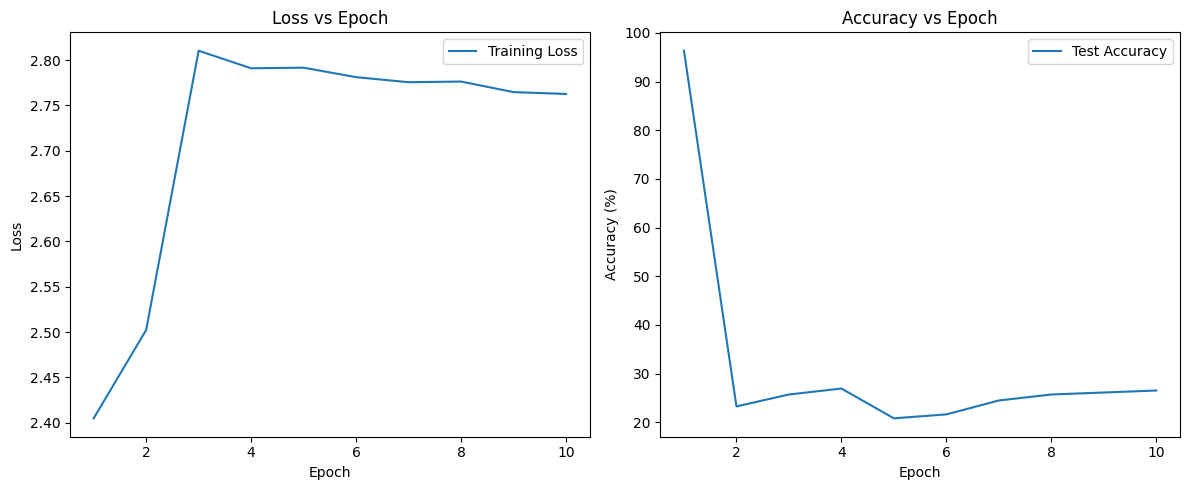


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.24      0.90      0.38        61
  meningioma       0.00      0.00      0.00        61
    no_tumor       0.10      0.02      0.03        62
   pituitary       0.10      0.02      0.03        61

    accuracy                           0.23       245
   macro avg       0.11      0.23      0.11       245
weighted avg       0.11      0.23      0.11       245



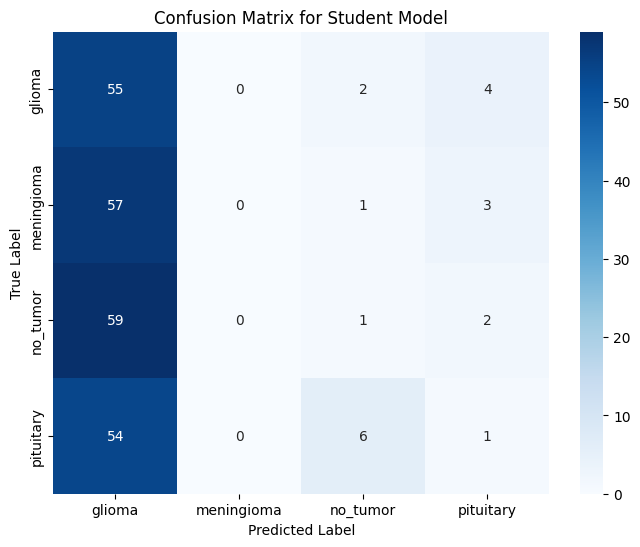

In [12]:
root_path = "/Users/siyran/Downloads/brisc2025/classification_task/test"
print("Path to dataset files:", root_path)


image_paths = []
labels = []

for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

max_samples = df['label'].value_counts().max()
balanced_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max_samples, replace=True, random_state=42)
).reset_index(drop=True)

df = balanced_df[['image_path', 'label']]
df['label'] = pd.Categorical(df['label'], categories=['glioma', 'meningioma', 'no_tumor', 'pituitary'])

train_loader, test_loader, CLASS_NAMES = get_data_loaders(df, img_size=224, batch_size=32)

NUM_CLASSES = len(CLASS_NAMES)
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training on:", DEVICE)


teacher_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, NUM_CLASSES)
teacher_model.to(DEVICE)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

student_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
student_model.fc = nn.Linear(student_model.fc.in_features, NUM_CLASSES)
student_model.to(DEVICE)

ce_loss_fn = nn.CrossEntropyLoss()
kd_loss_fn = JGEKDLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

lambda_weight = 0.5
EPOCHS = 10

print(f"Starting JGEKD training on {DEVICE} for {EPOCHS} epochs...")
train_losses, test_accuracies = train_and_validate(
    student_model, teacher_model, train_loader, test_loader,
    optimizer, ce_loss_fn, kd_loss_fn, lambda_weight, EPOCHS, DEVICE
)

plot_metrics(train_losses, test_accuracies)
evaluate_metrics(student_model, test_loader, DEVICE, CLASS_NAMES)


Path to dataset files: /Users/siyran/Downloads/brisc2025/classification_task/test


/var/folders/cg/5bwxxnzs74n3k54n54wbwcjh0000gn/T/ipykernel_68531/3355111553.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label', group_keys=False).apply(


Starting JGEKD training on cpu for 10 epochs...
Epoch 1/10, Train Loss: 2.3785, Test Accuracy: 74.69%
Epoch 2/10, Train Loss: 2.1729, Test Accuracy: 96.33%
Epoch 3/10, Train Loss: 2.1466, Test Accuracy: 97.14%
Epoch 4/10, Train Loss: 2.1451, Test Accuracy: 97.55%
Epoch 5/10, Train Loss: 2.1441, Test Accuracy: 97.14%
Epoch 6/10, Train Loss: 2.1401, Test Accuracy: 97.55%
Epoch 7/10, Train Loss: 2.1378, Test Accuracy: 97.96%
Epoch 8/10, Train Loss: 2.1359, Test Accuracy: 97.55%
Epoch 9/10, Train Loss: 2.1327, Test Accuracy: 98.37%
Epoch 10/10, Train Loss: 2.1313, Test Accuracy: 97.55%


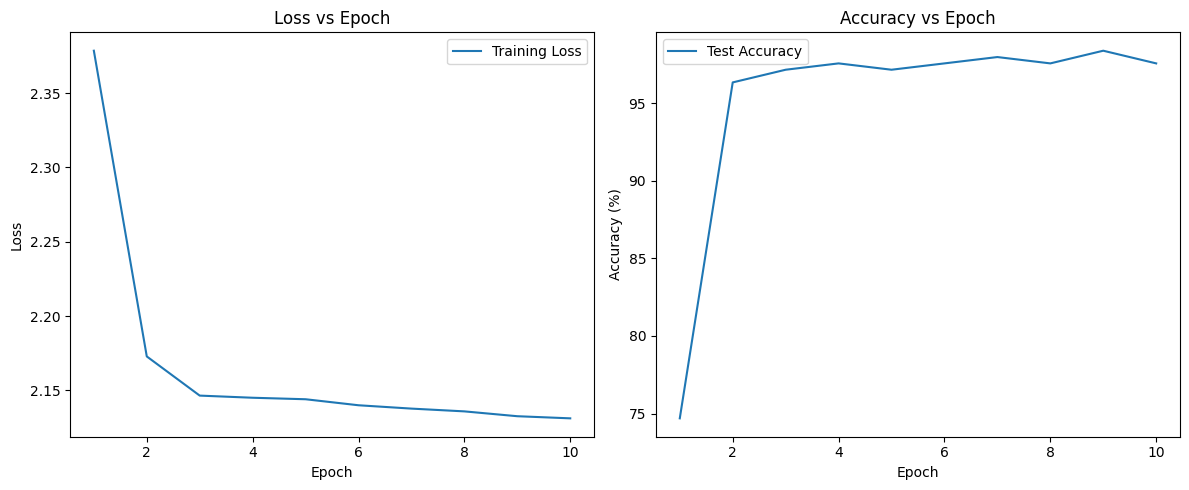


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.94      0.98      0.96        61
  meningioma       0.98      0.92      0.95        61
    no_tumor       0.98      1.00      0.99        62
   pituitary       1.00      1.00      1.00        61

    accuracy                           0.98       245
   macro avg       0.98      0.98      0.98       245
weighted avg       0.98      0.98      0.98       245



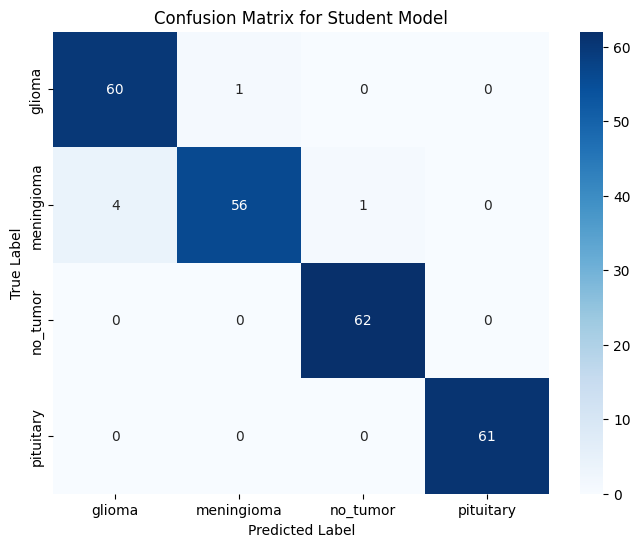